# 사진 스티커 앱 첫걸음
___

**설명**

본 예제에서는 openCV와 dlib 라이브러리를 이용하여 얼굴을 인식하고 스티커를 붙이는 사진 스티커 앱의 기본 기능을 구현해보고자 한다.

___

# 1) 사진 준비하기

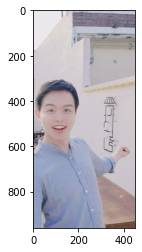

In [55]:
import cv2    # 이미지 채널을 BGR 순으로 사용
import matplotlib.pyplot as plt    # 이미지 채널을 RGB 순으로 사용
import numpy as np # 배열 처리
import os # 디렉토리 관리

my_img_path = os.getenv("HOME") + "/aiffel/camera_sticker/images/image.png"   # 사진이 경로 저장하기

# 이미지를 읽는 함수
def read_img(img):    # img = 이미지 파일의 이름
    img_bgr = cv2.imread(my_img_path, 1)    # openCV로 이미지 읽기, 1 : 컬러로 읽음
    img_bgr = cv2.resize(img_bgr, (img_bgr.shape[1] - img_bgr.shape[1]%10,img_bgr.shape[0] - img_bgr.shape[0]%10))    # 사진크기 Resize하기 (1의 자리수를 0으로 처리)   
    img_show_bgr = img_bgr.copy()    # 출력용 이미지 별도 저장하기
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # maplotlib 로 출력하기 위해 이미지 채널을 RGB 순으로 바꾸기
   
    return img_bgr, img_rgb, img_show_bgr

img_bgr, img_rgb, img_show_bgr = read_img("V_front.jpg")    # 이미지를 읽는 함수 불러오기

plt.imshow(img_rgb)    # matplotlib로 이미지 출력하기
plt.show()    # 화면에 이미지 출력하기

# 2) 얼굴 검출 (face detection)

이미지에서 얼굴이 어디에 있는지 Dilb 라이브러리를 활용하여 탐색한다.

___

bouding box 좌표 : rectangles[[(15, 387) (201, 573)]]


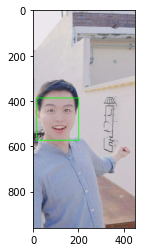

In [35]:
# 얼굴 검출하기
import dlib

# 사진 속 얼굴 bounding box로 표시하는 함수
def detect_face(img_rgb, img_show_bgr):    # img_rgb = 얼굴 검출(HOG)을 위한 이미지, img_show_bgr = bounding box 표시할 이미지
    detector_hog = dlib.get_frontal_face_detector()    # 얼굴 검출을 위한 detector 선언하기
    dlib_rects = detector_hog(img_rgb, 1)    # bounding box의 위치 (image, num of img pyramid)
    '''
    이미지를 upsamplig 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다.
    이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능합니다.
    '''
    
    print("bouding box 좌표 :", dlib_rects)   # 찾은 얼굴영역 좌표

    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show_bgr, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)    # img_show_bgr 사진에 bounding box 표시하기    
        # (image, start, end, color, thinkness)
        '''
        cv2.rectangle : 사각형 그리는 함수
        img : 그림을 그릴 이미지
        start : 사각형 사진 꼭짓점 좌표
        end : 사각형 종료 꼭짓점 좌표
        color : 선 색상 (BGR)
        thickness : 선의 두께
        lineType : 선 그리기 형식 (cv2.LINE_4, cv2.LINE_8, cv2.LINE_AA 중 선택)
        '''
    return dlib_rects

dlib_rects = detect_face(img_rgb, img_show_bgr)    # 사진 속 얼굴 bounding box로 표시하는 함수 불러오기
img_show_rgb =  cv2.cvtColor(img_show_bgr, cv2.COLOR_BGR2RGB)    # maplotlib 로 출력하기 위해 이미지 채널을 RGB 순으로 바꾸기
plt.imshow(img_show_rgb)    # matplotlib로 이미지 출력하기
plt.show()    # 화면에 이미지 출력하기

# 3) 얼굴 랜드마크 (face landmark) 검출

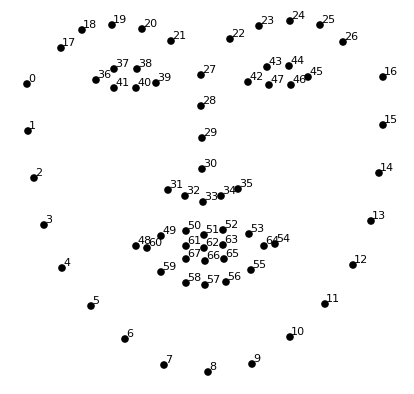


위 그림과 같이 각각의 좌표(랜드마크)가 주어지고, 이후 다양한 이미지를 붙이는데 활용할 수 있다.

___

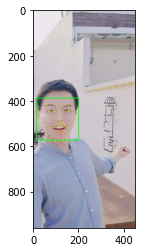

In [36]:
# 얼굴 랜드마크하기

# bounding box 속 얼굴의 이목구비를 랜드마크로 표시하는 함수
def face_landmark(dlib_rects, img_rgb, img_show_bgr):    # dlib_rects = bounding box 좌표, img_rgb = 랜드마크를 구하기 위한 이미지, img_show_bgr = 랜드마크를 표시할 이미지
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'    # 저장한 landmark 모델 불러오기
    landmark_predictor = dlib.shape_predictor(model_path)    # landmark 모델 선언

    list_landmarks = []    # 68개(0~67)의 이목구비 위치를 저장하는 리스트
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)    # 이목구비 위치 구하기
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))    # 이목구비 위치를 (x,y)형태로 저장합니다.
        list_landmarks.append(list_points)    # 이목구비 위치를 리스트에 저장합니다.


    # 랜드마크가 적용된 이미지 출력하기
    for landmark in list_landmarks:
        for idx, point in enumerate(list_points):
            #print(idx, point)
            cv2.circle(img_show_bgr, point, 2, (0, 255, 255), -1)    ## img_show_bgr 사진에 랜드마크 표시하기
            # (image, center, radian, color, thickness)
            '''
            cv2.cirlce : 원 그리는 함수
            image : 그림을 그릴 이미지
            center : 원의 중심 좌표
            radian : 반지름
            color : 선 색상 (BGR)
            thickness : 선의 두께, -1이면 원 안쪽을 채움
            '''
    
    return list_landmarks

list_landmarks = face_landmark(dlib_rects, img_rgb, img_show_bgr)    # bounding box 속 얼굴의 이목구비를 랜드마크로 표시하는 함수 불러오기
img_show_rgb = cv2.cvtColor(img_show_bgr, cv2.COLOR_BGR2RGB)    # maplotlib 로 출력하기 위해 이미지 채널을 RGB 순으로 바꾸기
plt.imshow(img_show_rgb)    # matplotlib로 이미지 출력하기
plt.show()    # 화면에 이미지 출력하기

# 4) 스티커 적용 위치 확인하기

이번에 사용할 이미지는 콧수염 이미지이다.
따라서 얼굴 랜드마크(좌표)를 기준으로 이미지가 어디에 위치해야 하는지,
좌표를 확인해야 한다.

___

In [37]:
# 이미지에 적용시킬 스티커 좌표 확인하기

# 이미지에 적용시킬 스티커의 좌표를 찾는 함수
def sticker_position(dlib_rects, list_landmarks):    # dlib_rects = bounding box 좌표, list_landmarks = 이목구비 위치 
    
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks): 
        # x = landmark[30][0]    # 왕관 스티커를 붙힐 x좌표
        # y = landmark[30][1] - dlib_rect.width()//2    # 왕관 스티커를 붙힐 y좌표

        x = landmark[30][0]    # 고양이 스티커의 중심 x좌표
        y = landmark[30][1]    # 고양이 스티커의 중심 y좌표

        # w = dlib_rect.width()    # bounding box의 너비
        # h = dlib_rect.height()    # bouding box의 높이
        
        w = (landmark[30][0] - landmark[2][0]) * 2    # 고양이 스티커의 너비
        h = (landmark[48][1] - landmark[30][1]) * 2    # 고양이 스티커의 높이
    
    return x, y, w, h

x, y, w, h = sticker_position(dlib_rects, list_landmarks)    # 이미지에 적용시킬 스티커의 좌표를 찾는 함수 불러오기
print ('Image center (x,y) : (%d,%d)'%(x,y))
print ('Image size (w,h) : (%d,%d)'%(w,h))

Image center (x,y) : (119,481)
Image size (w,h) : (178,72)


# 5) 스티커 적용하기

위에서 구한 좌표에 고양이 수염이미지를 적용한다.

___

top-left (x,y) : (30,445)


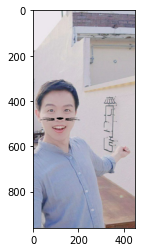

In [38]:
# 고양이 스티커 이미지를 읽어서 적용하기

# 사진 속 얼굴에 고양이 수염을 붙히는 함수
def attach_sticker(x, y, w, h, img_bgr, sticker):    # x, y, w, h = 고양이 수염 스티커의 위치와 크기, img_bgr = 고양이 수염을 붙힐 이미지, sticker = 고양이 수염 스티커의 파일의 이름 
    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png' # 고양이 수염 스티커가 저장된 위치
    img_sticker = cv2.imread(sticker_path)    # openCV로 고양이 스티커 이미지 읽기
    img_sticker = cv2.resize(img_sticker, (w,h))    # 고양이 스티커 이미지 resize 하기

    # 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표 입니다.
    refined_x = x - w // 2    # left
    refined_y = y - h // 2    # top
    print ('top-left (x,y) : (%d,%d)'%(refined_x, refined_y))
    
    # 스티커 이미지의 y축이 음수인 경우 (스티커 이미지가 위쪽을 벗어난 경우)
    if (refined_y < 0):
        img_sticker = img_sticker[-refined_y:]    # 원본 이미지의 범위를 벗어난 스티커 부분을 제거하기
        refined_y = 0    # top 의 y 좌표값을 원본 이미지의 경계 값으로 수정하기
       
    # 스티커 이미지의 y축이 원본 이미지의 최대 y축보다 큰 경우 (스티커 이미지가 아래쪽을 벗어난 경우)
    if ((refined_y + h) > img_bgr.shape[0]):
        img_sticker = img_sticker[:img_bgr.shape[0]-refined_y]    # 원본 이미지의 범위를 벗어난 스티커 부분을 제거하기
   
    # 스티커 이미지의 x축이 음수인 경우 (스티커 이미지가 왼쪽을 벗어난 경우)
    if (refined_x < 0): 
        img_sticker = img_sticker[:, -refined_x:, :]    # 원본 이미지의 범위를 벗어난 스티커 부분을 제거하기
        refined_x = 0    # left 의 x 좌표값을 원본 이미지의 경계 값으로 수정하기
    
    # 스티커 이미지의 x축이 원본 이미지의 최대 x축보다 큰 경우 (스티커 이미지가 오른쪽을 벗어난 경우)
    if ((refined_x + w) > img_bgr.shape[1]):
        img_sticker = img_sticker[:, :img_bgr.shape[1]-refined_x, :]     # 원본 이미지의 범위를 벗어난 스티커 부분을 제거하기
    
    # 원본 이미지에 스티커 적용하기
    sticker_area = img_bgr[refined_y:refined_y+h, refined_x:refined_x+w]    # 원본 이미지에 스티커를 적용시킬 부분
    img_bgr[refined_y:refined_y+h, refined_x:refined_x+w] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    # 스티커 이미지색이 255인 부분(하얀색)은 원본 이미지 색(sticker_area)을 칠하고,
    # 스티커 이미지색이 255가 아닌 부분(하얀색이외의 모든색)은 스티커 이미지색(img_sticker)을 칠한다.
    # (255,255,255) == 하얀색

attach_sticker(x, y, w, h, img_bgr, "cat-whiskers.png")    # 사진 속 얼굴에 고양이 수염을 붙히는 함수 불러오기
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))    # maplotlib 로 출력하기 위해 이미지 채널을 RGB 순으로 바꾸고, matplotlib로 이미지 출력하기
plt.show()    # 화면에 이미지 출력하기

# 6) 다양한 사진에 스티커 적용해보기

이번엔 다양한 사진에 모델을 적용해봄으로써,
문제점은 발생하지 않는지 살펴보자.

___

1. 표정과 각도가 다른 사진

___

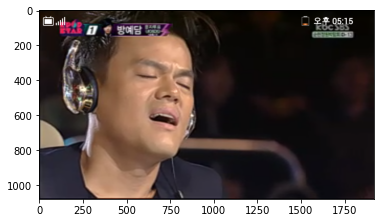

bouding box 좌표 : rectangles[[(418, 172) (972, 726)]]
Image center (x,y) : (790,458)
Image size (w,h) : (892,318)
top-left (x,y) : (344,299)


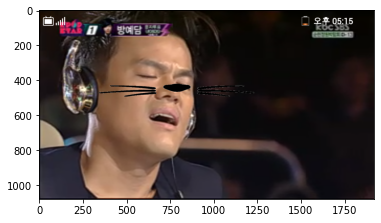

In [57]:
# 준비한 다른 사진 읽기

my_img_path1 = os.getenv("HOME") + "/aiffel/camera_sticker/images/jyp.png"   # 사진이 경로 저장하기

# 이미지를 읽는 함수
def read_img(img):    # img = 이미지 파일의 이름
    img_bgr = cv2.imread(my_img_path1, 1)    # openCV로 이미지 읽기, 1 : 컬러로 읽음
    img_bgr = cv2.resize(img_bgr, (img_bgr.shape[1] - img_bgr.shape[1]%10,img_bgr.shape[0] - img_bgr.shape[0]%10))    # 사진크기 Resize하기 (1의 자리수를 0으로 처리)   
    img_show_bgr = img_bgr.copy()    # 출력용 이미지 별도 저장하기
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # maplotlib 로 출력하기 위해 이미지 채널을 RGB 순으로 바꾸기
   
    return img_bgr, img_rgb, img_show_bgr

img_bgr, img_rgb, img_show_bgr = read_img("V_front.jpg")    # 이미지를 읽는 함수 불러오기

plt.imshow(img_rgb)    # matplotlib로 이미지 출력하기
plt.show()    # 화면에 이미지 출력하기

# 얼굴 검출하기
dlib_rects = detect_face(img_rgb, img_show_bgr)
img_show_rgb =  cv2.cvtColor(img_show_bgr, cv2.COLOR_BGR2RGB)

# 얼굴 랜드마크하기
list_landmarks = face_landmark(dlib_rects, img_rgb, img_show_bgr)
img_show_rgb = cv2.cvtColor(img_show_bgr, cv2.COLOR_BGR2RGB)

# 이미지에 적용시킬 스티커 좌표 확인하기
x, y, w, h = sticker_position(dlib_rects, list_landmarks)
print ('Image center (x,y) : (%d,%d)'%(x,y))
print ('Image size (w,h) : (%d,%d)'%(w,h))

# 고양이 스티커 이미지를 읽어서 적용하기
attach_sticker(x, y, w, h, img_bgr, "cat-whiskers.png")
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

2. 글씨가 들어간 사진, 흑백 이미지 분석
___

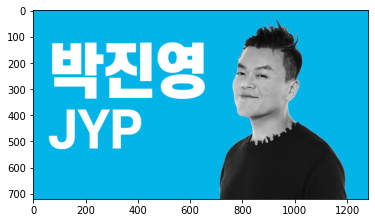

bouding box 좌표 : rectangles[[(736, 167) (959, 390)]]
Image center (x,y) : (805,280)
Image size (w,h) : (82,96)
top-left (x,y) : (764,232)


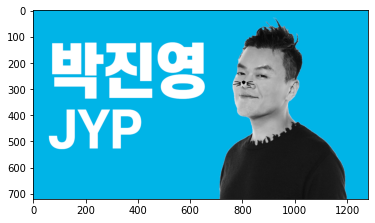

In [58]:
# 준비한 다른 사진 읽기

my_img_path1 = os.getenv("HOME") + "/aiffel/camera_sticker/images/jyp3.png"   # 사진이 경로 저장하기

# 이미지를 읽는 함수
def read_img(img):    # img = 이미지 파일의 이름
    img_bgr = cv2.imread(my_img_path1, 1)    # openCV로 이미지 읽기, 1 : 컬러로 읽음
    img_bgr = cv2.resize(img_bgr, (img_bgr.shape[1] - img_bgr.shape[1]%10,img_bgr.shape[0] - img_bgr.shape[0]%10))    # 사진크기 Resize하기 (1의 자리수를 0으로 처리)   
    img_show_bgr = img_bgr.copy()    # 출력용 이미지 별도 저장하기
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # maplotlib 로 출력하기 위해 이미지 채널을 RGB 순으로 바꾸기
   
    return img_bgr, img_rgb, img_show_bgr

img_bgr, img_rgb, img_show_bgr = read_img("V_front.jpg")    # 이미지를 읽는 함수 불러오기

plt.imshow(img_rgb)    # matplotlib로 이미지 출력하기
plt.show()    # 화면에 이미지 출력하기

# 얼굴 검출하기
dlib_rects = detect_face(img_rgb, img_show_bgr)
img_show_rgb =  cv2.cvtColor(img_show_bgr, cv2.COLOR_BGR2RGB)

# 얼굴 랜드마크하기
list_landmarks = face_landmark(dlib_rects, img_rgb, img_show_bgr)
img_show_rgb = cv2.cvtColor(img_show_bgr, cv2.COLOR_BGR2RGB)

# 이미지에 적용시킬 스티커 좌표 확인하기
x, y, w, h = sticker_position(dlib_rects, list_landmarks)
print ('Image center (x,y) : (%d,%d)'%(x,y))
print ('Image size (w,h) : (%d,%d)'%(w,h))

# 고양이 스티커 이미지를 읽어서 적용하기
attach_sticker(x, y, w, h, img_bgr, "cat-whiskers.png")
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

3. 각도와 표정이 다르고, 다른 물체가 얼굴에 있는 사진

___

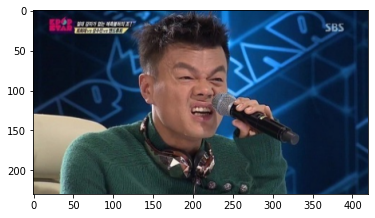

bouding box 좌표 : rectangles[[(151, 44) (259, 152)]]
Image center (x,y) : (219,100)
Image size (w,h) : (134,52)
top-left (x,y) : (152,74)


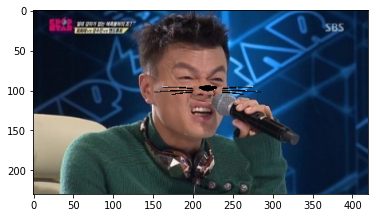

In [59]:
# 준비한 다른 사진 읽기

my_img_path1 = os.getenv("HOME") + "/aiffel/camera_sticker/images/jyp4.png"   # 사진이 경로 저장하기

# 이미지를 읽는 함수
def read_img(img):    # img = 이미지 파일의 이름
    img_bgr = cv2.imread(my_img_path1, 1)    # openCV로 이미지 읽기, 1 : 컬러로 읽음
    img_bgr = cv2.resize(img_bgr, (img_bgr.shape[1] - img_bgr.shape[1]%10,img_bgr.shape[0] - img_bgr.shape[0]%10))    # 사진크기 Resize하기 (1의 자리수를 0으로 처리)   
    img_show_bgr = img_bgr.copy()    # 출력용 이미지 별도 저장하기
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # maplotlib 로 출력하기 위해 이미지 채널을 RGB 순으로 바꾸기
   
    return img_bgr, img_rgb, img_show_bgr

img_bgr, img_rgb, img_show_bgr = read_img("V_front.jpg")    # 이미지를 읽는 함수 불러오기

plt.imshow(img_rgb)    # matplotlib로 이미지 출력하기
plt.show()    # 화면에 이미지 출력하기

# 얼굴 검출하기
dlib_rects = detect_face(img_rgb, img_show_bgr)
img_show_rgb =  cv2.cvtColor(img_show_bgr, cv2.COLOR_BGR2RGB)

# 얼굴 랜드마크하기
list_landmarks = face_landmark(dlib_rects, img_rgb, img_show_bgr)
img_show_rgb = cv2.cvtColor(img_show_bgr, cv2.COLOR_BGR2RGB)

# 이미지에 적용시킬 스티커 좌표 확인하기
x, y, w, h = sticker_position(dlib_rects, list_landmarks)
print ('Image center (x,y) : (%d,%d)'%(x,y))
print ('Image size (w,h) : (%d,%d)'%(w,h))

# 고양이 스티커 이미지를 읽어서 적용하기
attach_sticker(x, y, w, h, img_bgr, "cat-whiskers.png")
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

**결론**

사진이 사이즈가 조절되고, 얼굴 마크다운에 맞게 들어가지만, 얼굴 각도가 달라지거나 표정이 일그러 졌을 경우 마크다운 위치가 조정되어 해당 위치보다 조금 위로 위치하는 것을 알수 있다.

1. 우측 상단을 향한 얼굴, 특이한 표정
얼굴과 표정이 우측 상단을 향하게 되어 마크다운이 우측 상단으로 이동되었다.
또한 이미지 크기가 얼굴에 비해 많이 커졌다.

2. 왼쪽을 향한 얼굴, 사이즈 조정
얼굴이 왼쪽으로 향하였고, 상대적으로 작은 얼굴로 조정되어 보인다.
이미지 크기 또한 작아졌다.

3. 우측 상단을 향한 얼굴, 마이크가 일부 나옴
1번 이미지와 유사하지만, 마이크(다른 물체)가 나왔을 경우에도 
얼굴 인식에 대해 문제가 발생하지 않았다.



**개선할 점**

1. 이미지(고양이 수염)가 얼굴 방향에 따라 각도 또한 변해야 알맞게 적용될 수 있다.

2. 표정으로 인해서 마크다운이 왜곡될 경우, 이미지 크기가 크게 변할 수도 있다는 점이 있어서, Dilb 라이브러리를 개선, 최적화 하는 노력이 필요해 보인다.



**회고**

이번 예제를 진행하면서 먼저는 비교하고자 하는 이미지 파일 확장자가 달라서, 오류가 발생하였다. 같은 확장자의 이미지 파일을 적용하였을때 잘 작동하였고, 이후에 다른 예제 진행시에도 이와 같이 확장자를 신경써야 겠다.

또한 위 개선할 점 2번에서, 표정이 많이 일그러질 때는 랜드마크를 잘 잡을수 있는 방법이 또 없을지 연구해보고 싶다.